In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/health-and-sleep-statistics/Health_Sleep_Statistics.csv


In [2]:
df = pd.read_csv('/kaggle/input/health-and-sleep-statistics/Health_Sleep_Statistics.csv')

# Data Overview

In [3]:
df.head()

,User ID,Age,Gender,Sleep Quality,Bedtime,Wake-up Time,Daily Steps,Calories Burned,Physical Activity Level,Dietary Habits,Sleep Disorders,Medication Usage
0,1,25,f,8,23:00,06:30,8000,2500,medium,healthy,no,no
1,2,34,m,7,00:30,07:00,5000,2200,low,unhealthy,yes,yes
2,3,29,f,9,22:45,06:45,9000,2700,high,healthy,no,no
3,4,41,m,5,01:00,06:30,4000,2100,low,unhealthy,yes,no
4,5,22,f,8,23:30,07:00,10000,2800,high,medium,no,no


In [4]:
df.shape

(100, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   User ID                  100 non-null    int64 
 1   Age                      100 non-null    int64 
 2   Gender                   100 non-null    object
 3   Sleep Quality            100 non-null    int64 
 4   Bedtime                  100 non-null    object
 5   Wake-up Time             100 non-null    object
 6   Daily Steps              100 non-null    int64 
 7   Calories Burned          100 non-null    int64 
 8   Physical Activity Level  100 non-null    object
 9   Dietary Habits           100 non-null    object
 10  Sleep Disorders          100 non-null    object
 11  Medication Usage         100 non-null    object
dtypes: int64(5), object(7)
memory usage: 9.5+ KB


In [6]:
df.isnull().sum()

User ID                    0
Age                        0
Gender                     0
Sleep Quality              0
Bedtime                    0
Wake-up Time               0
Daily Steps                0
Calories Burned            0
Physical Activity Level    0
Dietary Habits             0
Sleep Disorders            0
Medication Usage           0
dtype: int64

In [7]:
df[df.duplicated]

,User ID,Age,Gender,Sleep Quality,Bedtime,Wake-up Time,Daily Steps,Calories Burned,Physical Activity Level,Dietary Habits,Sleep Disorders,Medication Usage


In [8]:
df.drop('User ID', axis = 1 , inplace = True)

# Visualization

In [9]:
df_num = ['Age','Sleep Quality','Daily Steps', 'Calories Burned']

**Distribution(Numerical features)**

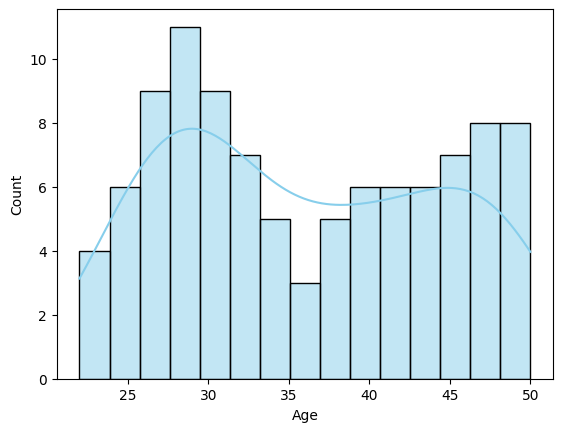

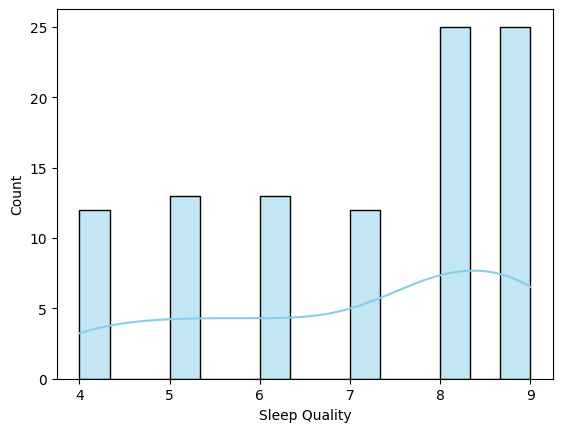

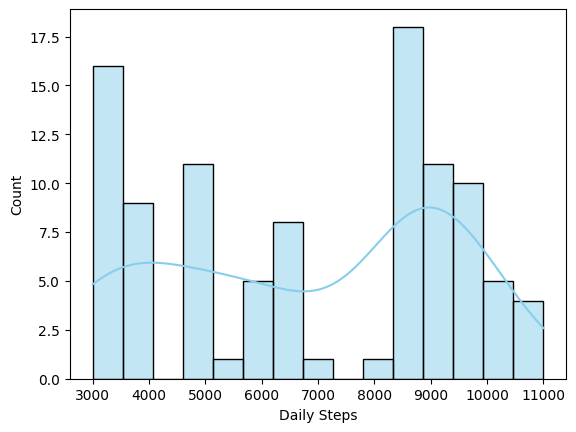

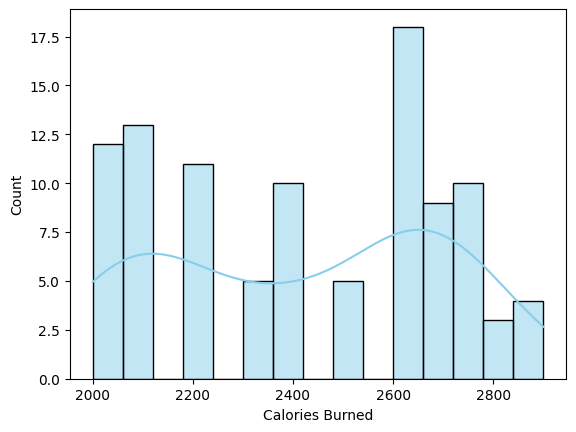

In [10]:
for col in df_num:
    sns.histplot(x = col, data = df, bins = 15, kde = True, color = 'skyblue')
    plt.show()

**Distribution of Categorical features**

In [11]:
df_cat = df.select_dtypes(include = ['object'])

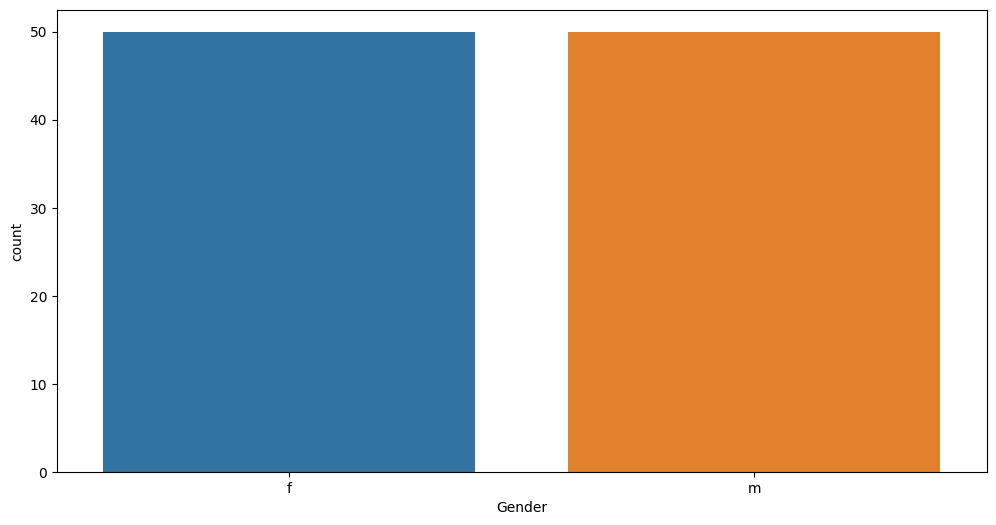

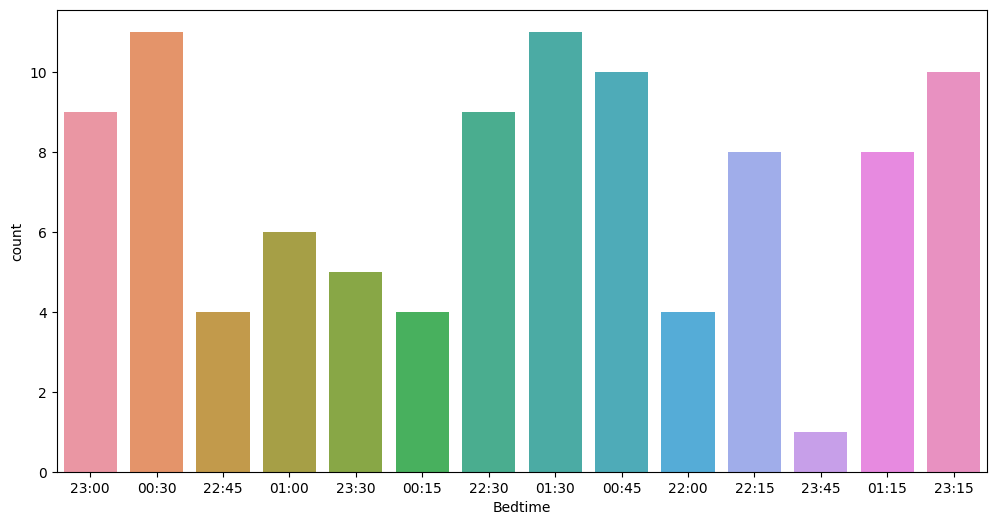

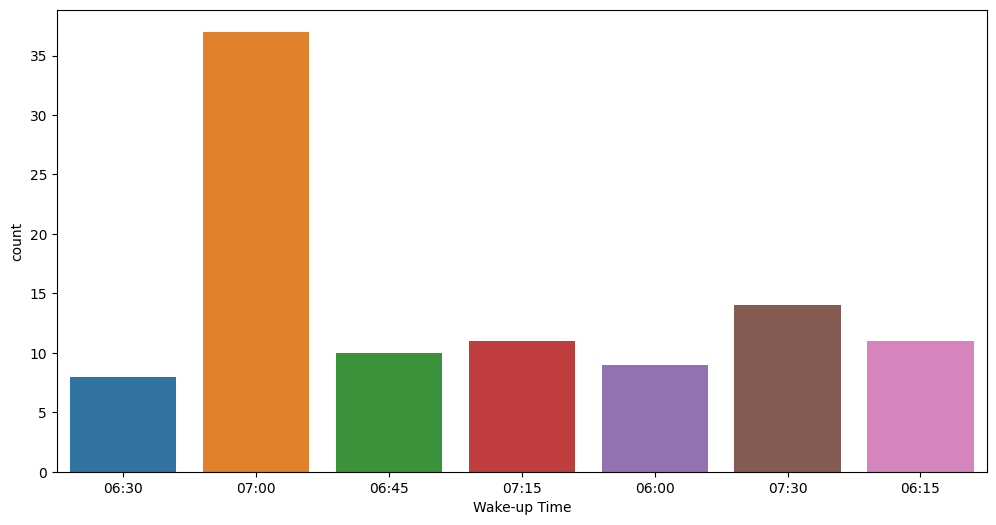

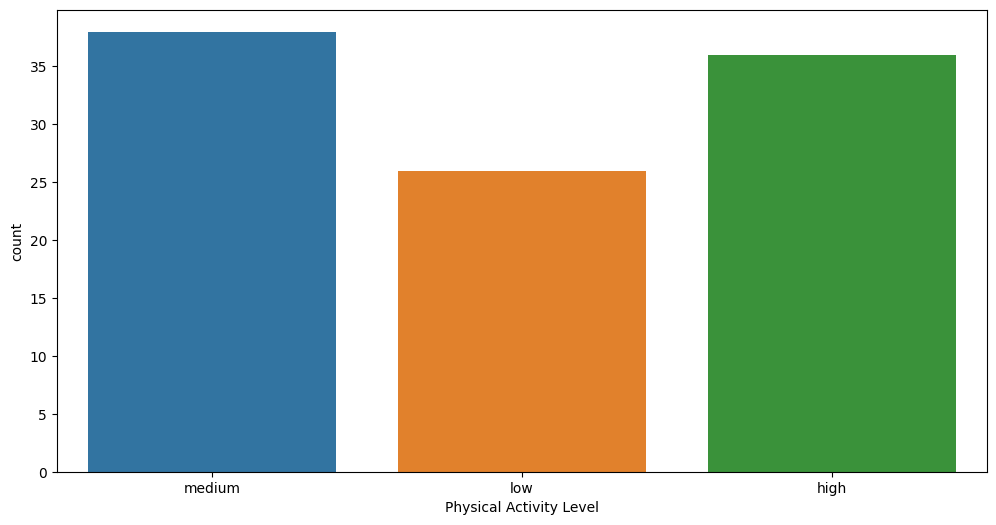

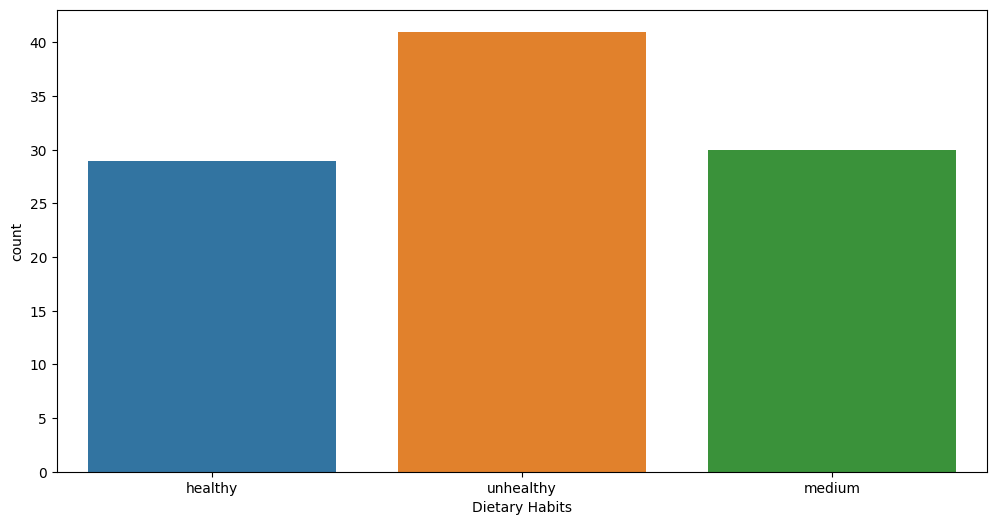

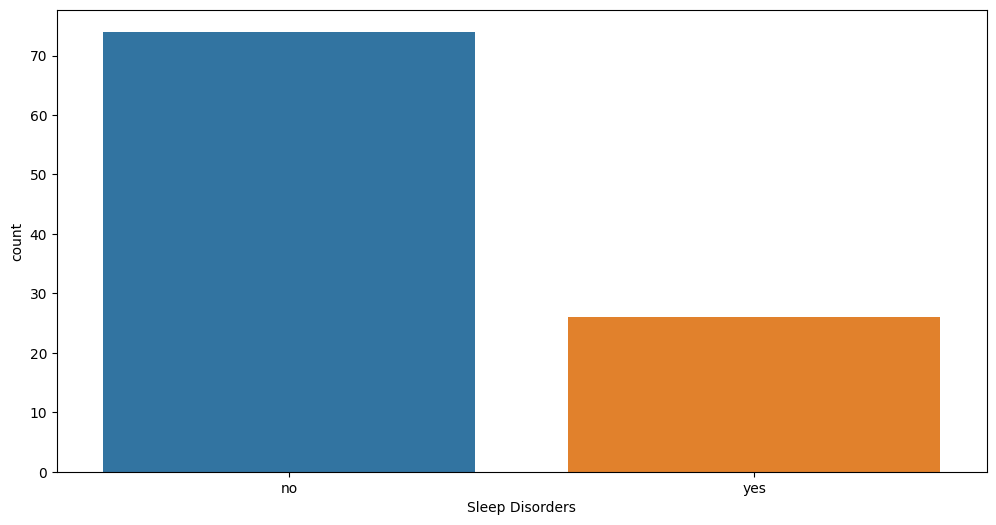

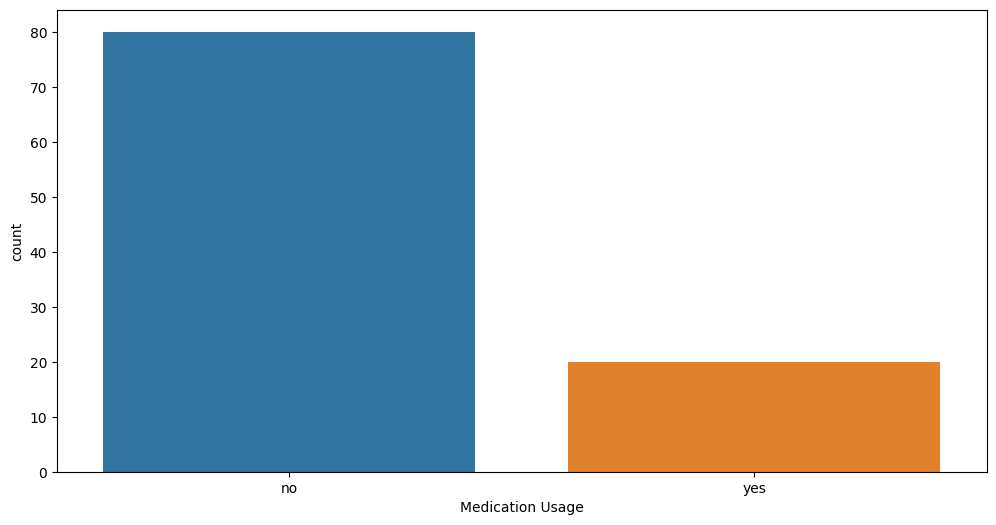

In [12]:
for col in df_cat:
    plt.figure(figsize = (12,6))
    sns.countplot(x = col, data = df)
    plt.show()

# Correlation

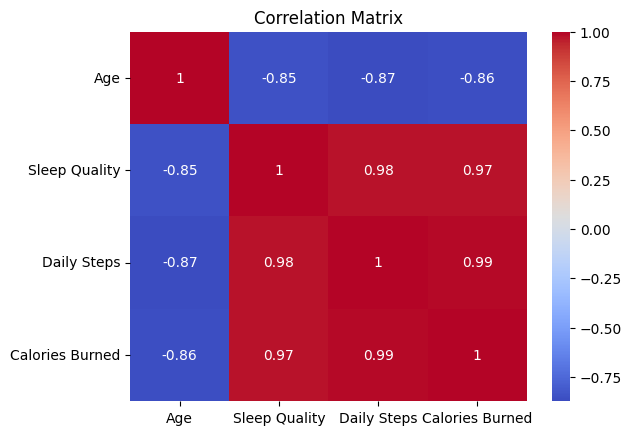

In [13]:
cm = df[['Age', 'Sleep Quality', 'Daily Steps', 'Calories Burned']].corr()
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Interpretation

Age has a negative correlation with all other variables. Specifically:

Sleep Quality: -0.85, meaning as age increases, sleep quality tends to decrease.
Daily Steps: -0.87, indicating that older individuals tend to take fewer steps.
Calories Burned: -0.86, showing that older people tend to burn fewer calories.
Sleep Quality has a strong positive correlation with:

Daily Steps: 0.98, suggesting that better sleep quality is associated with taking more steps.
Calories Burned: 0.97, indicating that better sleep quality is linked to burning more calories.
Daily Steps has a very strong positive correlation with:

Calories Burned: 0.99, which makes sense since burning more calories is typically associated with taking more steps.
In summary:

Age is negatively correlated with physical activity and sleep quality.
Sleep Quality, Daily Steps, and Calories Burned are strongly positively correlated with each other.







# Descriptive statistics

In [14]:
df.describe()

,Age,Sleep Quality,Daily Steps,Calories Burned
count,100.000000,100.000000,100.000000,100.00000
mean,36.010000,7.000000,6830.000000,2421.00000
std,8.454865,1.734964,2498.706736,281.06759
min,22.000000,4.000000,3000.000000,2000.00000
25%,28.750000,5.750000,4750.000000,2175.00000
50%,35.000000,7.500000,6750.000000,2400.00000
75%,44.000000,8.250000,9000.000000,2700.00000
max,50.000000,9.000000,11000.000000,2900.00000


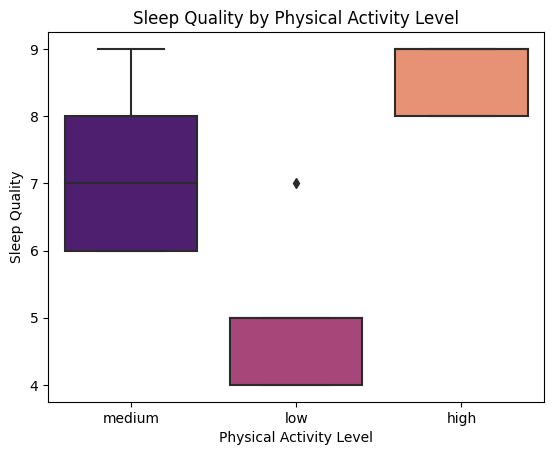

In [15]:
sns.boxplot(x='Physical Activity Level', y='Sleep Quality', data=df, palette = 'magma')
plt.title('Sleep Quality by Physical Activity Level')
plt.show()

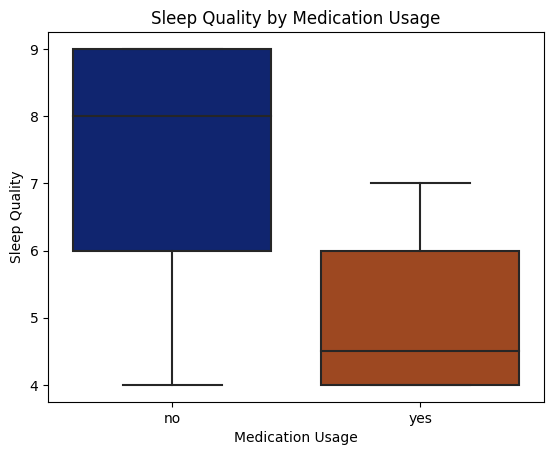

In [16]:
sns.boxplot(x='Medication Usage', y='Sleep Quality', data=df, palette = 'dark')
plt.title('Sleep Quality by Medication Usage')
plt.show()

# Linear Regression

In [17]:
categorical_features = ['Gender', 'Physical Activity Level', 'Dietary Habits', 'Sleep Disorders', 'Medication Usage']
numeric_features = ['Age', 'Daily Steps', 'Calories Burned']

X = df[categorical_features + numeric_features]
y = df['Sleep Quality']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', 'passthrough', numeric_features)
    ])

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

print("Model R^2 Score: ", model.score(X_test, y_test))

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

Model R^2 Score:  0.9577274939105904
Mean Absolute Error (MAE): 0.25126664889803163
Mean Squared Error (MSE): 0.1330527129164165


# Residual Plot

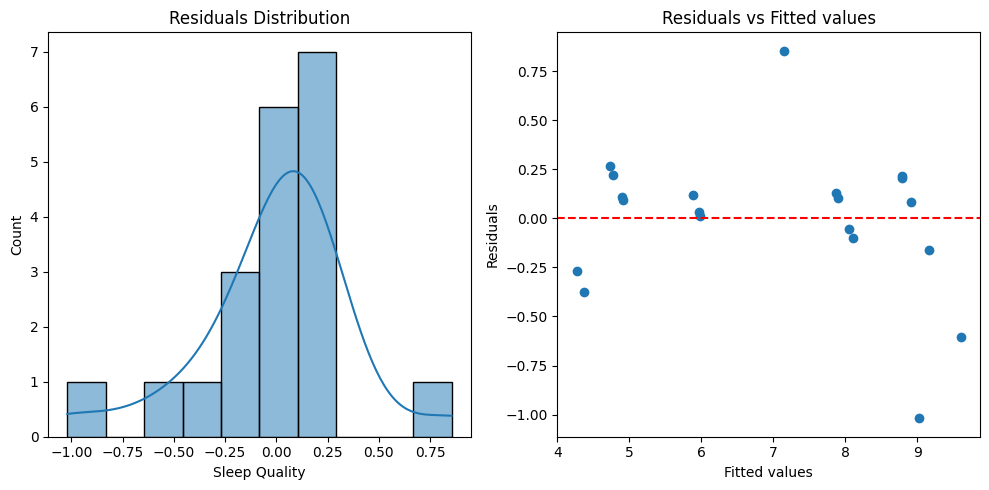

In [18]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')

plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted values')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()
